In [1]:
## Qt-1, Qt-2, Pt-1, T(max,t-1),  
#Reading /Users/mezzatab/Dropbox/Hydrology/Data/Data/hydrology.nws.noaa.gov/pub/gcip/mopex/US_Data/Us_438_Daily ## 
# It has Q,P, evaporation, tmax, tmin #
import pandas as pd 
import numpy as np
import warnings
import itertools
import statsmodels.api as sm



import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import sklearn
print sklearn.__version__
from sklearn.model_selection import ShuffleSplit, train_test_split
from CastFloatCastInt import castFloat, castInt 
%matplotlib inline

Path="/Users/mezzatab/Dropbox/Hydrology/Data/Data/hydrology.nws.noaa.gov/pub/gcip/mopex/US_Data/Us_438_Daily/"
PathQ="/Users/mezzatab/Dropbox/Hydrology/Data/Data/hydrology.nws.noaa.gov/pub/gcip/mopex/US_Data/Daily Q 1800/"
ImagePath="/Users/mezzatab/Dropbox/Hydrology-ML/Images/"

#Link=https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#
#https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb#

0.19.1


In [2]:
## Check specfic area : 03451500.dly # 
## Reading Data ## 
pathFile=Path+"03451500.dly"
pathQFile=PathQ+"03451500.dq"
startYear=1948 ## 

f=open(pathFile) 
data=f.readlines()

fQ=open(pathQFile) 
dataQ=fQ.readlines()

In [3]:
#dataFrame=pd.DataFrame()#columns=["Time","precipitation","evaporation","discharge","Tmax","Tmin"])
rows=0
x=0
Time=[]
Prec=[]
Eva=[]
Discharge=[]
Tmax=[]
Tav=[]
Tmin=[]
for line in data:
    List=line.split()
    Row=[]
    L=len(List)
    if L == 8: 
        time=List[0]+'0'+List[1]+'0'+List[2]
        x=3
    if L == 7:
        time=List[0]+'0'+List[1]#+List[2]
#        print time
        x=2
    if L == 6:
        time=List[0]
        x=1
    year=castInt(time)/10000
    if year >= startYear:
        Time.append(castInt(time))
        Prec.append(castFloat(List[x]))
        Eva.append(castFloat(List[x+1]))
        Discharge.append(castFloat(List[x+2]))
        Tmax.append(castFloat(List[x+3]))
        Tmin.append(castFloat(List[x+4]))
        Tav.append((castFloat(List[x+3])+castFloat(List[x+4]))/2.0)
    rows=rows+1
#dataFrame=pd.DataFrame({'Time':Time,'P':Prec, 'Eva':Eva, 'Discharge':Discharge,'T':Tav, 'Tmax':Tmax,'Tmin':Tmin })
#dataFrame=pd.DataFrame({'Time':Time,'P':Prec, 'Eva':Eva, 'Q':Discharge,'Tmax':Tmax,'Tmin':Tmin })

## Reading Q data from Different file ## 
File="/Users/mezzatab/Dropbox/Hydrology/Data/Data/hydrology.nws.noaa.gov/pub/gcip/mopex/US_Data/Daily Q 1800/"

In [4]:
## Reading Q data from Different file ## 
qTime=[]
Q=[]
for line in dataQ[1:]:
#    month=[]
    Month=line.split()
    year=castInt(Month[0])/100
    month=castInt(Month[0])-100*year
    if year >= startYear:     
        for i,t in enumerate(Month[1:]):
            try:
                if castFloat(t) > 0:
                    Q.append(castFloat(t))
                    if i < 9:
                        time=Month[0]+'0'+str(i+1)
                    else:
                        time=Month[0]+str(i+1)
                    qTime.append(time)
            except ValueError:
                pass

In [5]:
# The last data for Q is 2002-09-30, which is 19997 elements or Q[19996]
dataFrame=pd.DataFrame({'Time':Time[:19997],'Q':Q[:19997], 'P':Prec[:19997], 'PET':Eva[:19997],'Discharge':Discharge[:19997],'T':Tav[:19997],'Tmax':Tmax[:19997],'Tmin':Tmin[:19997] })
#print len(Q)
#print len(Time[:19997])

## tranforming dataframe from daily to monthly average ## 

In [6]:
line=dataFrame.loc[0,"Time"]
monthOld=int(line/100)-100*(int(line/10000))
mFrac=(monthOld-1)/12.0
year=int(line/10000)+mFrac
time=int(line/100)
qav=0
Tmin_av=0
Tmax_av=0
Ev_av=0
Pav=0
T_av=0
count=0

Time=[]
Prec=[]
Eva=[]
Discharge=[]
Tmax=[]
Tav=[]
Tmin=[]
for i in range(len(dataFrame.loc[:,"Time"])):
    line=dataFrame.loc[i,"Time"]
    month=int(line/100)-100*(int(line/10000))

    if month==monthOld:
        count=count+1
        qav+=dataFrame.loc[i,"Q"]
        Pav+=dataFrame.loc[i,"P"]
        T_av+=dataFrame.loc[i,"T"]
        Tmin_av+=dataFrame.loc[i,"Tmin"]
        Tmax_av+=dataFrame.loc[i,"Tmax"]
        Ev_av+=dataFrame.loc[i,"PET"]
    else:
        qav/=count
#        Pav/=count
        T_av/=count
        Tmin_av/=count
        Tmax_av/=count
        Ev_av/=count

        Time.append(year)
        time=int(line/100)    
        Prec.append(Pav)     
        Tav.append(T_av)
        Eva.append(Ev_av)
        Tmax.append(Tmax_av)
        Tmin.append(Tmin_av)
        Discharge.append(qav)
        mFrac=(month-1)/12.0
        year=int(line/10000)+mFrac

        
        count=0
        monthOld=month
        qav=0
        Pav=0
        T_av=0
        Tmin_av=0
        Tmax_av=0
        Ev_av=0
MonthFrame=pd.DataFrame({'Time':Time,'P':Prec, 'PET':Eva, 'Q':Discharge,'T':Tav, 'Tmax':Tmax,'Tmin':Tmin })

## Reading the new set of Data ## 2004-2017

In [7]:
## Reading New Years Data ## 
Path_NewData="/Users/mezzatab/Dropbox/Hydrology/Data/Data/Codes/New_Data/"
P_NY="Precipitation_2014-2018" 
Q_NY="Discharge_2004-2018"
T_NY="All_T.csv"

In [8]:
PathP=Path_NewData+P_NY
PathQ=Path_NewData+Q_NY
PathT=Path_NewData+T_NY
fN_P=open(PathP) 
dataN_P=fN_P.readlines()

fN_Q=open(PathQ) 
dataN_Q=fN_Q.readlines()

fN_T=open(PathT) 
dataN_T=fN_T.readlines()

In [9]:
# Q, starting line is 33
# P, starting line is 32 
#print dataN_Q[33:38]
#print dataN_P[32:38]
TimeT_N=[]
Tmax_N=[]
Tav_N=[]
Tmin_N=[]
for i,line in enumerate(dataN_T[28:]):
    List=line.split(",")
    length=len(List)
    tav=(castFloat(List[length-3])-32)*(5.0/9.0)
    tmax=(castFloat(List[length-2])-32)*(5.0/9.0)
    tmin=(castFloat(List[length-1])-32)*(5.0/9.0)
    Tav_N.append(tav)
    Tmax_N.append(tmax)
    Tmin_N.append(tmin)
#    TimeT_N.append(List[6])
#    print List[5] 
    date=List[6].split('-')
    TimeT_N.append(castInt(date[0])+(castInt(date[1])-1)/12.0)

In [10]:
#dataFrame=pd.DataFrame()#columns=["Time","precipitation","evaporation","discharge","Tmax","Tmin"])
## Reading new Discharge from 2004 -> Upfront 
unitChange=0.0283168466 
rows=0
x=0
TimeQ=[]
YearQ=[]
MonthQ=[]
DayQ=[]
#Prec=[]
##Eva=[]
DischargeQ=[]
##Tmax=[]
##Tav=[]
##Tmin=[]
for i,line in enumerate(dataN_Q[33:]):
    List=line.split()
    length=len(List)
    DischargeQ.append(unitChange*castFloat(List[length-2]))
    date=List[2].split('-')
    YearQ.append(castInt(date[0]))
    MonthQ.append(castInt(date[1]))
    DayQ.append(castInt(date[2]))
    time=10000*castInt(date[0])+100*castInt(date[1])+castInt(date[2])
    TimeQ.append(time)
#dataFrameN_Q=pd.DataFrame({'Year':Year,'Month':Month, 'Day':Day, 'Discharge':Discharge,'T':Tav, 'Tmax':Tmax,'Tmin':Tmin })#columns=["Time","precipitation","evaporation","discharge","Tmax","Tmin"])

In [11]:
## Reading new Precipation from 2004-> # CLeaning the missing data with their yearly average #
unitChange=25.4
YearP=[]
MonthP=[]
DayP=[]
PrecP=[]
TimeP=[]
for i,line in enumerate(dataN_P[32:]):
    List=line.split()
    length=len(List)
    date=List[2].split('-')
    YearP.append(castInt(date[0]))
    MonthP.append(castInt(date[1]))
    DayP.append(castInt(date[2]))
    time=10000*castInt(date[0])+100*castInt(date[1])+castInt(date[2])
    TimeP.append(time)    
    if length!=3:
        PrecP.append(unitChange*castFloat(List[length-2]))
    else:
        PrecP.append(-0.1)

In [12]:
yearLength=[366,365,365,365,366,365,365,365,366,365,365,365,366,365]
yearAc=[]
Sum=0
for i in range(len(yearLength)):
    Sum=Sum+yearLength[i]
    yearAc.append(Sum)
missing=[]
avPrec=[]
startYear=2004
for i in range(366):
    year=0
    count=0
    avprec=0
    j=i
    if PrecP[i] < 0:
        avprec=0
    else:
        avprec=avprec+PrecP[i]
    while year < len(yearLength)-1:
        j=j+yearLength[year]
        year=year+1
        if PrecP[j] > -0.1:
            avprec=avprec+PrecP[j]
            count=count+1
    avprec=avprec/(count+1)
    avPrec.append(avprec)
#plt.clf()
#plt.plot(avPrec)
#plt.show()
## Update the Prec to replace absent data with average ## 
for i,prec in enumerate(PrecP):
    if PrecP[i]==-0.1:
        year=YearP[i]-2004
#        print year
        if year==0:
            PrecP[i]=avPrec[i]
        else:
#            print i-yearAc[year-1]
            PrecP[i]=avPrec[i-yearAc[year-1]]

In [13]:
line=TimeQ[0]
monthOld=int(line/100)-100*(int(line/10000))
mFrac=(monthOld-1)/12.0
year=int(line/10000)+mFrac
time=int(line/100)
qav=0
Pav=0
count=0

M_Time=[]
M_Prec=[]
M_Dis=[]
M_Eva=[]

for i in range(len(TimeQ)): ## To make things in the same size ## 
    line=TimeQ[i]
    month=int(line/100)-100*(int(line/10000))
#    if int(line/100) >= 201800:
#        break 
    if month==monthOld:
        count=count+1
        qav+=DischargeQ[i]
        Pav+=PrecP[i]
#        T_av+=dataFrame.loc[i,"T"]
#        Tmin_av+=dataFrame.loc[i,"Tmin"]
#        Tmax_av+=dataFrame.loc[i,"Tmax"]
#        Ev_av+=dataFrame.loc[i,"PET"]
    else:
        qav/=count
#        Pav/=count
        M_Time.append(year)
        time=int(line/100)    
        M_Prec.append(Pav)     
        M_Eva.append(0)
        M_Dis.append(qav)
        mFrac=(month-1)/12.0
        year=int(line/10000)+mFrac

        
        count=0
        monthOld=month
        qav=0
        Pav=0
#New_MonthFrame=pd.DataFrame({'Time':Time,'P':Prec, 'PET':Eva, 'Q':Discharge,'T':Tav, 'Tmax':Tmax,'Tmin':Tmin })

In [14]:
Min= min(len(TimeT_N),len(M_Time))
#print Min
bNewData=len(Time) # Beginning of new data # 
lNewData=Min
testStart=480 # Beginning of 1988 # 
print bNewData
print lNewData
print testStart
print Min+bNewData
MonthFrame_WithNew=pd.DataFrame({'Time':Time[:bNewData-8]+TimeT_N[:Min],'P':Prec[:bNewData-8]+M_Prec[:Min], 'PET':Eva[:bNewData-8]+M_Eva[:Min], 'Q':Discharge[:bNewData-8]+M_Dis[:Min],'T':Tav[:bNewData-8]+Tav_N[:Min], 'Tmax':Tmax[:bNewData-8]+Tmax_N[:Min],'Tmin':Tmin[:bNewData-8]+Tmin_N[:Min] })

656
168
480
824


In [15]:
avP=[]
avT=[]
avQ=[]
avPET=[]
avTmin=[]
avTmax=[]
sumPET=[0]*12
sumP=[0]*12
sumT=[0]*12
sumQ=[0]*12
sumTmax=[0]*12
sumTmin=[0]*12

count=0
year=1
for i in range(len(MonthFrame_WithNew)):
#    count=count+1
    sumPET[count]=sumPET[count]+MonthFrame_WithNew.loc[i,"PET"]    
    sumP[count]=sumP[count]+MonthFrame_WithNew.loc[i,"P"]
    sumT[count]=sumT[count]+MonthFrame_WithNew.loc[i,"T"]
    sumQ[count]=sumQ[count]+MonthFrame_WithNew.loc[i,"Q"]
    sumTmin[count]=sumTmin[count]+MonthFrame_WithNew.loc[i,"Tmin"]    
    sumTmax[count]=sumTmax[count]+MonthFrame_WithNew.loc[i,"Tmax"]
    avP.append(sumP[count]/year)
    avT.append(sumT[count]/year)
    avQ.append(sumQ[count]/year)
    avPET.append(sumPET[count]/year)
    avTmin.append(sumTmin[count]/year)
    avTmax.append(sumTmax[count]/year)
    count=count+1
    if count==12:
        year=year+1
        count=0
MonthFrame_WithNew.loc[:,"avTmax"]=avTmax
MonthFrame_WithNew.loc[:,"avTmin"]=avTmin
MonthFrame_WithNew.loc[:,"avT"]=avT
MonthFrame_WithNew.loc[:,"avP"]=avP
MonthFrame_WithNew.loc[:,"avQ"]=avQ
MonthFrame_WithNew.loc[:,"avPET"]=avPET

In [16]:
## Holdridge life zones: https://en.wikipedia.org/wiki/Holdridge_life_zones ##
# Calculate Biotemperature: Sum (0<T<30)/12
BioT=[]
YEAR=[]
PANN=[]
PATR=[]
yearOld=int(MonthFrame_WithNew.loc[0,"Time"])
YEAR.append(yearOld)
#print year
bioT=0
pann=0
for i in range(len(MonthFrame_WithNew["Time"])):
    time=MonthFrame_WithNew.loc[i,"Time"]
    year=int(time)
    if year == yearOld:
        pann=pann+MonthFrame_WithNew.loc[i,"avP"]
        if MonthFrame_WithNew.loc[i,"avT"] < 30 and 0 < MonthFrame_WithNew.loc[i,"avT"]:
            bioT=bioT+MonthFrame_WithNew.loc[i,"avT"]
    else:
        YEAR.append(year)        
        bioT=bioT/12.0
        print bioT
        BioT.append(bioT)
        patr=bioT*58.93/pann
        PATR.append(patr)
        PANN.append(pann)
        if MonthFrame_WithNew.loc[i,"avT"] < 30 and 0 < MonthFrame_WithNew.loc[i,"avT"]:
            bioT=MonthFrame_WithNew.loc[i,"avT"]
        else:
            bioT=0
        pann=MonthFrame_WithNew.loc[i,"avP"]
        yearOld=year

bioT=bioT/12.0        
BioT.append(bioT)
patr=bioT*58.93/pann
PATR.append(patr)
PANN.append(pann)
YearFrame_WithNew=pd.DataFrame({'Time':YEAR,'BioT':BioT, 'PATR':PATR, 'PANN':PANN})

13.537090990264756
13.743412265566604
13.632018910689927
13.553471641377387
13.532436033750514
13.537106591379297
13.524493653311426
13.50051510497285
13.485935410883547
13.484130831587441
13.406091694637526
13.404911510713392
13.350191725543361
13.308263299365008
13.287436149685476
13.248643071730463
13.229335936514369
13.232884719657973
13.193688465815876
13.16655561141078
13.1384753321624
13.110840607927727
13.12464258054286
13.13361812828578
13.128429343014774
13.139061894910972
13.14779479348647
13.159227992569676
13.139215356289172
13.148120414832905
13.14100531984475
13.128405246707706
13.128754801977395
13.117775166230082
13.124079432538245
13.109226670700673
13.108779155447195
13.116152437079963
13.132055652294829
13.130369891495123
13.115565589044929
13.108574042427662
13.124838535946308
13.133826289853305
13.119941674146782
13.114328597524716
13.110789390613803
13.10517785395767
13.094088611202396
13.077115070991967
13.088922820864589
13.094048052776197
13.089861043438567
13

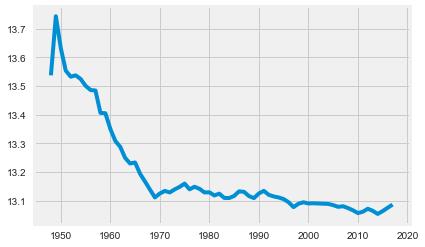

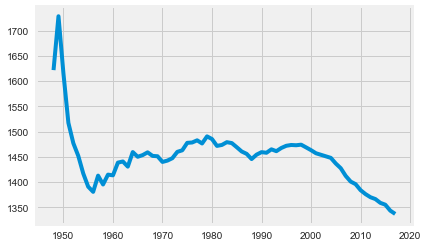

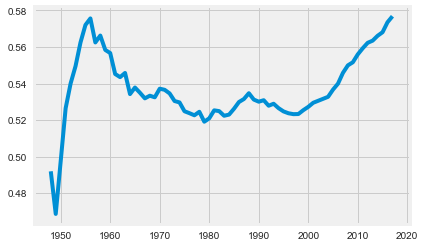

PATR    0.537109
dtype: float64
BioT    13.197535
dtype: float64
PANN    1450.011174
dtype: float64


In [21]:
## Warm Temperature Moist Forest 
plt.clf()
plt.plot(YearFrame_WithNew[["Time"]],YearFrame_WithNew[["BioT"]])#,".") # 13.3 , 1450 ml, 0.52
#plt.ylim(0,10)
plt.show()
plt.clf()
plt.plot(YearFrame_WithNew[["Time"]],YearFrame_WithNew[["PANN"]])#,".")
#plt.ylim(0,10)
plt.show()
plt.clf()
plt.plot(YearFrame_WithNew[["Time"]],YearFrame_WithNew[["PATR"]])#,".")
#plt.ylim(0,10)
plt.show()

print (YearFrame_WithNew[["PATR"]].mean())
print (YearFrame_WithNew[["BioT"]].mean())
print (YearFrame_WithNew[["PANN"]].mean())

            $Q$       $P$     $PET$       $T$
$Q$    1.000000  0.634781 -0.146090 -0.300807
$P$    0.634781  1.000000  0.073293  0.044713
$PET$ -0.146090  0.073293  1.000000  0.906101
$T$   -0.300807  0.044713  0.906101  1.000000


<Figure size 432x288 with 0 Axes>

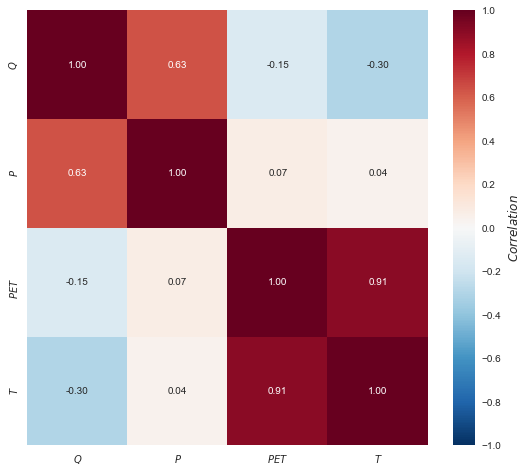

In [17]:
frame=MonthFrame.copy()
frame[["$Q$"]]=MonthFrame[["Q"]]
frame[["$P$"]]=MonthFrame[["P"]]
frame[["$T$"]]=MonthFrame[["T"]]
frame[["$PET$"]]=MonthFrame[["PET"]]
Corr=frame[["$Q$","$P$","$PET$","$T$"]].corr()
print Corr
import seaborn as sns
plt.clf()
fig, ax = plt.subplots(figsize=(8,8))
#plt.title("Correlation betweet features on the montly scale")
sns.heatmap(Corr,annot=True, vmin=-1.0, vmax=1.0,cbar_kws={'label':'$Correlation$',"ticks":[-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]},fmt='0.2f')
plt.savefig("Images/MonthlyCorrelation.eps")
plt.savefig("Images/MonthlyCorrelation.png")
plt.show()

In [18]:
meanQ=MonthFrame_WithNew["Q"].mean()
minQ=MonthFrame_WithNew["Q"].min()
maxQ=MonthFrame_WithNew["Q"].max()
stdQ=MonthFrame_WithNew["Q"].std()
print MonthFrame_WithNew["Q"].describe()
print "\n"

meanP=MonthFrame_WithNew["P"].mean()
minP=MonthFrame_WithNew["P"].min()
maxP=MonthFrame_WithNew["P"].max()
stdP=MonthFrame_WithNew["P"].std()
print MonthFrame_WithNew["P"].describe()
print "\n"

meanPet=MonthFrame_WithNew["PET"].mean()
minPet=MonthFrame_WithNew["PET"].min()
maxPet=MonthFrame_WithNew["PET"].max()
stdPet=MonthFrame_WithNew["PET"].std()
print MonthFrame_WithNew["PET"].describe()
print "\n"


print MonthFrame_WithNew["T"].describe()
print "\n"
meanT=MonthFrame_WithNew["T"].mean()
minT=MonthFrame_WithNew["T"].min()
maxT=MonthFrame_WithNew["T"].max()
stdT=MonthFrame_WithNew["T"].std()

print MonthFrame_WithNew["Tmax"].describe()
print "\n"
meanTmax=MonthFrame_WithNew["Tmax"].mean()
minTmax=MonthFrame_WithNew["Tmax"].min()
maxTmax=MonthFrame_WithNew["Tmax"].max()
stdTmax=MonthFrame_WithNew["Tmax"].std()

print MonthFrame_WithNew["Tmin"].describe()
print "\n"
meanTmin=MonthFrame_WithNew["Tmin"].mean()
minTmin=MonthFrame_WithNew["Tmin"].min()
maxTmin=MonthFrame_WithNew["Tmin"].max()
stdTmin=MonthFrame_WithNew["Tmin"].std()

meanAvQ_m=MonthFrame_WithNew["avQ"].mean()
minAvQ_m=MonthFrame_WithNew["avQ"].min()
maxAvQ_m=MonthFrame_WithNew["avQ"].max()
stdAvQ_m=MonthFrame_WithNew["avQ"].std()
print MonthFrame_WithNew["avQ"].describe()
print "\n"


meanAvT_m=MonthFrame_WithNew["avT"].mean()
minAvT_m=MonthFrame_WithNew["avT"].min()
maxAvT_m=MonthFrame_WithNew["avT"].max()
stdAvT_m=MonthFrame_WithNew["avT"].std()
print MonthFrame_WithNew["avT"].describe()
print "\n"

meanAvTmin_m=MonthFrame_WithNew["avTmin"].mean()
minAvTmin_m=MonthFrame_WithNew["avTmin"].min()
maxAvTmin_m=MonthFrame_WithNew["avTmin"].max()
stdAvTmin_m=MonthFrame_WithNew["avTmin"].std()
print MonthFrame_WithNew["avTmin"].describe()
print "\n"

meanAvTmax_m=MonthFrame_WithNew["avTmax"].mean()
minAvTmax_m=MonthFrame_WithNew["avTmax"].min()
maxAvTmax_m=MonthFrame_WithNew["avTmax"].max()
stdAvTmax_m=MonthFrame_WithNew["avTmax"].std()
print MonthFrame_WithNew["avTmax"].describe()
print "\n"

meanAvP_m=MonthFrame_WithNew["avP"].mean()
minAvP_m=MonthFrame_WithNew["avP"].min()
maxAvP_m=MonthFrame_WithNew["avP"].max()
stdAvP_m=MonthFrame_WithNew["avP"].std()
print MonthFrame_WithNew["avP"].describe()
print "\n"

count    816.000000
mean      58.290164
std       33.159044
min        9.602414
25%       34.867083
50%       51.167418
75%       74.777369
max      297.248774
Name: Q, dtype: float64


count    816.000000
mean     111.409166
std       60.264372
min        1.210000
25%       66.695000
50%      105.155000
75%      141.762500
max      332.830000
Name: P, dtype: float64


count    816.000000
mean       1.778382
std        1.333525
min        0.000000
25%        0.710400
50%        1.714833
75%        3.224700
max        3.774276
Name: PET, dtype: float64


count    816.000000
mean      13.085859
std        6.583101
min       -1.111111
25%        6.927733
50%       12.713150
75%       19.587866
max       24.290555
Name: T, dtype: float64


count    816.000000
mean      19.008816
std        7.168064
min        2.761667
25%       12.337958
50%       19.602037
75%       25.545698
max       31.353333
Name: Tmax, dtype: float64


count    816.000000
mean       7.163107
std        6.172412
min  

In [31]:
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
#scaledFrame=pd.DataFrame()
scaledFrame=MonthFrame_WithNew.copy()
scaledFrame[["Time"]]=MonthFrame_WithNew[["Time"]]
scaledFrame[["Q"]]=minmax_scale(MonthFrame_WithNew[["Q"]],feature_range=(0,1))
scaledFrame[["P"]]=minmax_scale(MonthFrame_WithNew[["P"]],feature_range=(0,1))
scaledFrame[["PET"]]=minmax_scale(MonthFrame_WithNew[["PET"]],feature_range=(0,1))
scaledFrame[["Tmin"]]=minmax_scale(MonthFrame_WithNew[["Tmin"]],feature_range=(0,1))
scaledFrame[["Tmax"]]=minmax_scale(MonthFrame_WithNew[["Tmax"]],feature_range=(0,1))
scaledFrame[["avTmin"]]=minmax_scale(MonthFrame_WithNew[["avTmin"]],feature_range=(0,1))
scaledFrame[["avTmax"]]=minmax_scale(MonthFrame_WithNew[["avTmax"]],feature_range=(0,1))
scaledFrame[["avP"]]=minmax_scale(MonthFrame_WithNew[["avP"]],feature_range=(0,1))
scaledFrame[["avT"]]=minmax_scale(MonthFrame_WithNew[["avT"]],feature_range=(0,1))
scaledFrame[["avQ"]]=minmax_scale(MonthFrame_WithNew[["avQ"]],feature_range=(0,1))

### Defining the metrics for evaluation of prediction ###

In [20]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from functools import partial
from collections import defaultdict 
from pprint import pprint

#import WB as WB

def WB(Yo,Yp):
    sum_o=0
    sum_p=0
    for i in range(len(Yo)):
        sum_o+=Yo[i]
        sum_p+=Yp[i]
    return 1-abs(1-sum_p/sum_o)

def NSE(Yo, Yp):
    sum_o=0
    sum_p=0
    for i in range(len(Yo)):
        sum_o+=Yo[i]
        sum_p+=Yp[i]
    meano=sum_o/len(Yo)
    meanp=sum_p/len(Yp)
    
    numerator=0
    denumerator=0
    for i in range(len(Yo)):
        numerator=numerator+(Yp[i]-Yo[i])**2
        denumerator=denumerator+(Yo[i]-meano)**2
    
    return 1-numerator/denumerator

METRICS = {
    "r2_score":r2_score, # NSE 
    "MSE":mean_squared_error,
    "WB":WB,
    "NSE":NSE
}

## Parameter Selection for the ARIMA Time Series Model ##
 p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days. #
d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.#
q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [41]:
#656
#168
#480
#824
# End line 815 , 2017-12 #
# Start Line 480, 1988-01 #
# Start Line, 480+167, 2004-01 #
# End Line, 480+166, 2001.83 #
#scaledFrame.loc[0,"Time"]
start = datetime.datetime.strptime("1948-01", "%Y-%m")
print start
date_list = [start + relativedelta(months=x) for x in range(0,480+168)]
start = datetime.datetime.strptime("2004-01", "%Y-%m")
date_new=[start + relativedelta(months=x) for x in range(0,816-480-168)]
#df['index'] =date_list
#df.set_index(['index'], inplace=True)
#df.index.name=None
#print scaledFrame['index']
print date_list[-1]
date=date_list+date_new
print len(date)
print scaledFrame.shape[:]
scaledFrame['index']=date
scaledFrame.set_index(['index'], inplace=True)
#date=date_list+date_new

#scaledFrame.index.name=None
#scaledFrame.reset_index(inplace=True)
#scaledFrame.drop(scaledFrame.index[815], inplace=True)
#scaledFrame.set_index(date, 'Date')
#scaledFrame.set_index['index']

1948-01-01 00:00:00
2001-12-01 00:00:00
816
(816, 14)


<Figure size 432x288 with 0 Axes>

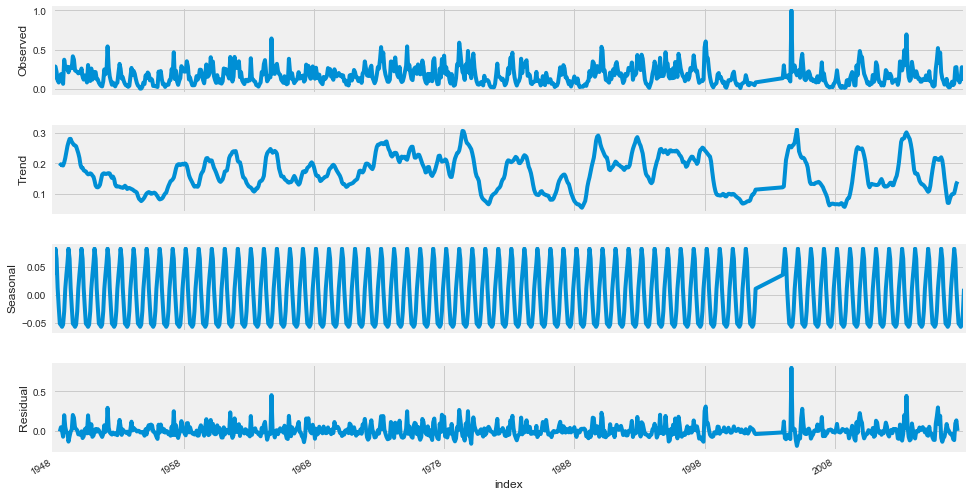

In [43]:
decomposition = seasonal_decompose(scaledFrame['Q'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)